In [1]:
import os
import sys

import pandas as pd
import torch

In [2]:
# Add the parent directory of 'src' to sys.path if not already present
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import src.assimilation.assimilator  # noqa: E402
import src.assimilation.test_configs  # noqa: E402, F401

In [3]:
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

mpl.rcParams["text.usetex"] = True
mpl.rc("text.latex", preamble=r"\usepackage{amsmath}")

In [4]:
# SAVE_ROOT = "../ass_results/assimilate_various_obs_freq"

# pickle_cache_path = "./plot_various_obs_freq.pkl"
# for filename in os.listdir(SAVE_ROOT):
#     if filename.endswith("transfered.pt") and 'sda' in filename:
#         file_path = os.path.join(SAVE_ROOT, filename)
#         print(file_path)
#         saved_data = torch.load(file_path, weights_only=False)
#         saved_data.pop("config")
#         print(saved_data.keys())
#         torch.save(saved_data, file_path[:-13] + "clipped.pt")

In [5]:
SAVE_ROOT = "../ass_results/assimilate_various_obs_freq"

pickle_cache_path = "./plot_various_obs_freq.pkl"

read_cache = 1

try:
    assert read_cache
    results = pd.read_pickle(pickle_cache_path)
except:  # noqa: E722
    entries = []
    cnt = 0
    for filename in os.listdir(SAVE_ROOT):
        if filename.endswith(".pt") and (not filename.endswith("transfered.pt")):
            file_path = os.path.join(SAVE_ROOT, filename)
            print(cnt, file_path)
            saved_data = torch.load(file_path, weights_only=False)
            if "seed_no" in saved_data:
                saved_data["seedno"] = saved_data["seed_no"]
            entry = pd.DataFrame(
                {
                    "obs_type": saved_data["obs_type"][0],
                    "method": saved_data["method"],
                    "rand_mask_ratio": saved_data["rand_mask_ratio"],
                    "seed_no": saved_data["seedno"],
                    "rmse": saved_data["rmse"],
                    "step_idx": range(len(saved_data["rmse"])),
                    "time_stride": saved_data["time_stride"],
                    "avg_rmse": sum(saved_data["rmse"]) / len(saved_data["rmse"]),
                }
            )
            entries.append(entry)
            cnt += 1
    results = pd.concat(entries)
    results.to_pickle(pickle_cache_path)

In [6]:
results

,obs_type,method,rand_mask_ratio,seed_no,rmse,step_idx,time_stride,avg_rmse
0,vor2vel,sda,1.00,0,13.081038,0,1,14.915712
1,vor2vel,sda,1.00,0,13.418297,1,1,14.915712
2,vor2vel,sda,1.00,0,16.320566,2,1,14.915712
3,vor2vel,sda,1.00,0,13.425264,3,1,14.915712
4,vor2vel,sda,1.00,0,16.883533,4,1,14.915712
...,...,...,...,...,...,...,...,...
4,sin3x,sda,0.01,4,1.907760,4,8,1.908246
5,sin3x,sda,0.01,4,1.902511,5,8,1.908246
6,sin3x,sda,0.01,4,1.897400,6,8,1.908246
7,sin3x,sda,0.01,4,1.892678,7,8,1.908246


In [7]:
results["method"] = results["method"].replace({"maa": "soad"})

In [8]:
count_keys = ["obs_type", "method", "rand_mask_ratio", "time_stride", "seed_no"]
for key in count_keys:
    print(key, ":", sorted(results[key].unique()))

obs_type : ['arctan3x', 'sin3x', 'vor2vel']
method : ['sda', 'soad']
rand_mask_ratio : [np.float64(0.01), np.float64(0.0625), np.float64(0.25), np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(10.0)]
time_stride : [np.int64(1), np.int64(2), np.int64(4), np.int64(8)]
seed_no : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [9]:
df = results

In [10]:
arctan3x = df[df["obs_type"] == "arctan3x"]
sin3x = df[df["obs_type"] == "sin3x"]
vor2vel = df[df["obs_type"] == "vor2vel"]

In [11]:
vor2vel["method"].unique()

array(['sda', 'soad'], dtype=object)

In [12]:
arctan3x_sda = arctan3x[arctan3x["method"] == "sda"]
arctan3x_soad = arctan3x[arctan3x["method"] == "soad"]

sin3x_sda = sin3x[sin3x["method"] == "sda"]
sin3x_soad = sin3x[sin3x["method"] == "soad"]

vor2vel_sda = vor2vel[vor2vel["method"] == "sda"]
vor2vel_soad = vor2vel[vor2vel["method"] == "soad"]

In [13]:
palette = ["#420802", "#822E24", "#C27067", "#FFCDC7"]
palette = ["#42040B", "#822833", "#C26D76", "#FFCFD4"]
palette = ["#2A3332", "#37615C", "#33A194", "#0FE0C8"]
palette = ["#0D3320", "#306149", "#78A18D", "#B4E0CA"]
palette = ["#072433", "#244D61", "#648CA1", "#D1DBE0"]
palette = ["#060933", "#242861", "#6468A1", "#D1D2E0"]
palette = ["#7B7AD6", "#E08D89", "#E0D189", "#89E1AB"]
# palette = ['#8CB1FF', '#FF82B9', '#FFDC8C', '#8DFF91']
palette = sns.palettes.color_palette(palette)

In [14]:
def step_wise_plot(df, ratio_label: str, save_path: str | None = None, ylim: tuple[float, float] | None = None):
    n_mask_params = len(df["rand_mask_ratio"].unique()) + 1
    ax = sns.lineplot(
        df,
        x="step_idx",
        y="rmse",
        hue="time_stride",
        style="rand_mask_ratio",
        errorbar="sd",
        palette=palette,
        style_order=df["rand_mask_ratio"].unique().tolist(),
    )

    handles, labels = ax.get_legend_handles_labels()

    ratio_handles = [handles[-n_mask_params]]
    ratio_labels = [labels[-n_mask_params]]

    idxs = [1, 2, 3, 4]
    for idx in idxs:
        ratio_handles.append(handles[-n_mask_params + idx])
        ratio_labels.append(labels[-n_mask_params + idx])

    ratio_hl = [ratio_handles, ratio_labels]

    # ratio_hl = [handles[-n_mask_params:], labels[-n_mask_params:]]
    stride_hl = [handles[:-n_mask_params], labels[:-n_mask_params]]

    ratio_hl[1][0] = ratio_label
    stride_hl[1][0] = "$N$"
    for k, s in enumerate(ratio_hl[1]):
        if s.endswith(".0"):
            ratio_hl[1][k] = s[:-2]

    hls = [ratio_hl[0] + stride_hl[0], ratio_hl[1] + stride_hl[1]]
    leg = ax.legend(*hls, loc="upper left", borderaxespad=0.0, ncols=2)
    ax.add_artist(leg)

    plt.xlabel("time step")
    plt.ylabel("RMSE")

    if ylim is not None:
        plt.ylim(ylim)

    if save_path is not None:
        plt.savefig(save_path)

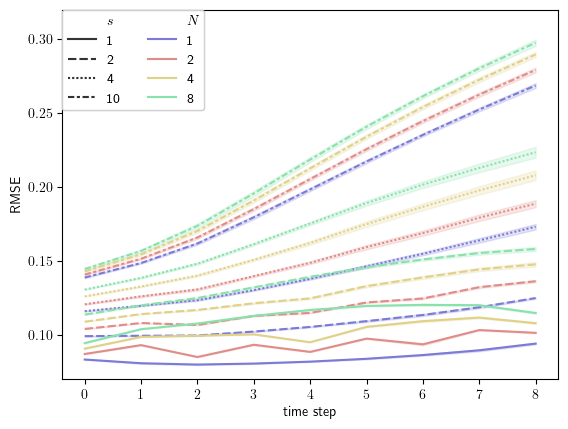

In [27]:
to_plot = arctan3x_soad[arctan3x_soad["rand_mask_ratio"] > 0.99]
to_plot = to_plot.sort_values(by="rand_mask_ratio", ascending=True)

step_wise_plot(to_plot, "$s$", "../figs/assimilate_with_prior_arctan3x_soad_s.pdf", ylim=(0.07, 0.32))

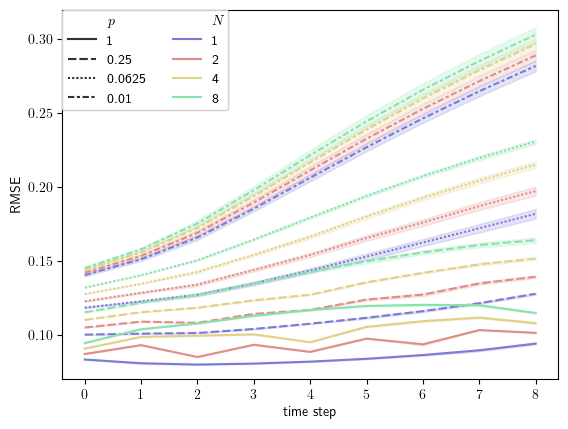

In [28]:
to_plot = arctan3x_soad[arctan3x_soad["rand_mask_ratio"] < 1.01]
to_plot = to_plot.sort_values(by="rand_mask_ratio", ascending=False)

step_wise_plot(to_plot, "$p$", "../figs/assimilate_with_prior_arctan3x_soad_p.pdf", ylim=(0.07, 0.32))

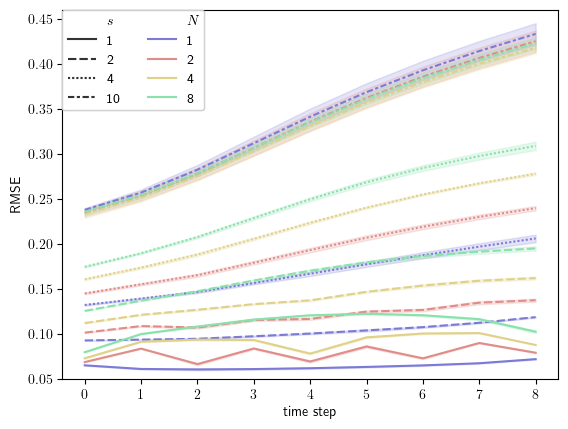

In [26]:
to_plot = sin3x_soad[sin3x_soad["rand_mask_ratio"] > 0.99]
to_plot = to_plot.sort_values(by="rand_mask_ratio", ascending=True)

step_wise_plot(to_plot, "$s$", "../figs/assimilate_with_prior_sin3x_soad_s.pdf", ylim=(0.05, 0.46))

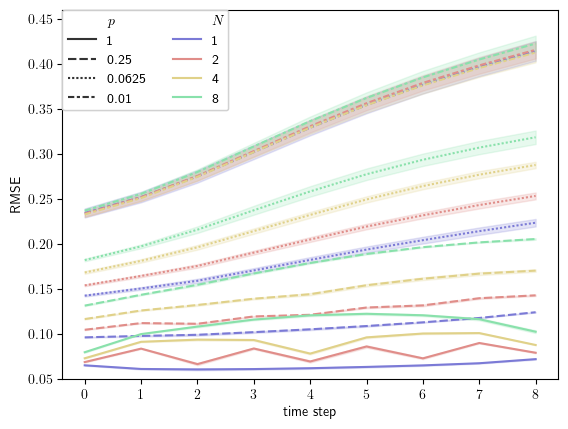

In [25]:
to_plot = sin3x_soad[sin3x_soad["rand_mask_ratio"] < 1.01]
to_plot = to_plot.sort_values(by="rand_mask_ratio", ascending=False)

step_wise_plot(to_plot, "$p$", "../figs/assimilate_with_prior_sin3x_soad_p.pdf", ylim=(0.05, 0.46))

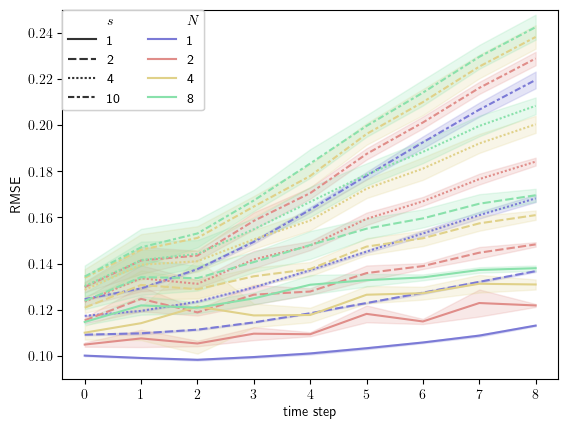

In [24]:
to_plot = vor2vel_soad[vor2vel_soad["rand_mask_ratio"] > 0.99]
to_plot = to_plot.sort_values(by="rand_mask_ratio", ascending=True)

step_wise_plot(to_plot, "$s$", "../figs/assimilate_with_prior_vor2vel_soad_s.pdf", ylim=(0.09, 0.25))

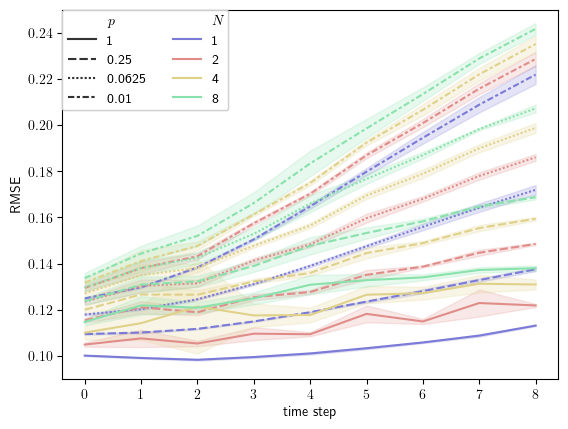

In [23]:
to_plot = vor2vel_soad[vor2vel_soad["rand_mask_ratio"] < 1.01]
to_plot = to_plot.sort_values(by="rand_mask_ratio", ascending=False)

step_wise_plot(to_plot, "$p$", "../figs/assimilate_with_prior_vor2vel_soad_p.pdf", ylim=(0.09, 0.25))

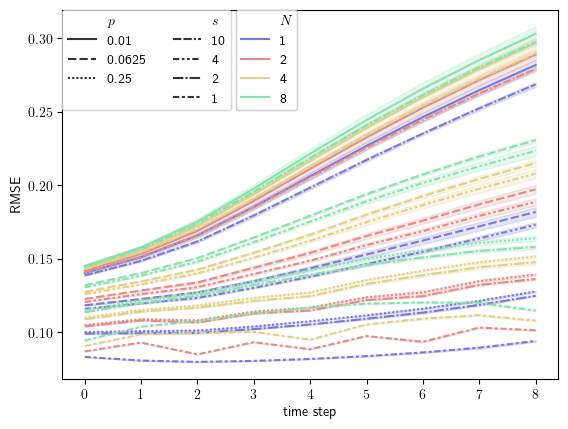

In [78]:
to_plot = arctan3x_soad
n_mask_params = len(to_plot["rand_mask_ratio"].unique()) + 1
ax = sns.lineplot(
    to_plot, x="step_idx", y="rmse", hue="time_stride", style="rand_mask_ratio", errorbar="sd", palette=palette
)

handles, labels = ax.get_legend_handles_labels()

ratio_handles = [handles[-n_mask_params]]
ratio_labels = [labels[-n_mask_params]]
# 1st column
idxs = [1, 2, 3]
for idx in idxs:
    ratio_handles.append(handles[-n_mask_params + idx])
    ratio_labels.append(labels[-n_mask_params + idx])

# 2nd column
ratio_handles.append(handles[-n_mask_params])  # empty style
ratio_labels.append("")  # empty string
ratio_handles.append(handles[-n_mask_params])  # empty style
ratio_labels.append("")  # empty string
idxs = [7, 6, 5, 4]
for idx in idxs:
    ratio_handles.append(handles[-n_mask_params + idx])
    ratio_labels.append(labels[-n_mask_params + idx])
ratio_hl = [ratio_handles, ratio_labels]

# ratio_hl = [handles[-n_mask_params:], labels[-n_mask_params:]]
stride_hl = [handles[:-n_mask_params], labels[:-n_mask_params]]

ratio_hl[1][0] = "$p$"
ratio_hl[1][5] = "$s$"
stride_hl[1][0] = "$N$"
for k, s in enumerate(ratio_hl[1]):
    if s.endswith(".0"):
        ratio_hl[1][k] = s[:-2]

ratio_leg = ax.legend(*ratio_hl, loc="upper left", borderaxespad=0.0, ncols=2)
stride_leg = ax.legend(*stride_hl, loc="upper left", bbox_to_anchor=(0.35, 1.0), borderaxespad=0.0)

ax.add_artist(ratio_leg)
ax.add_artist(stride_leg)

plt.xlabel("time step")
plt.ylabel("RMSE")

plt.savefig("../figs/assimilate_with_prior_arctan3x_soad.pdf")
# plt.ylim(.1, .5)
# plt.yscale('log')

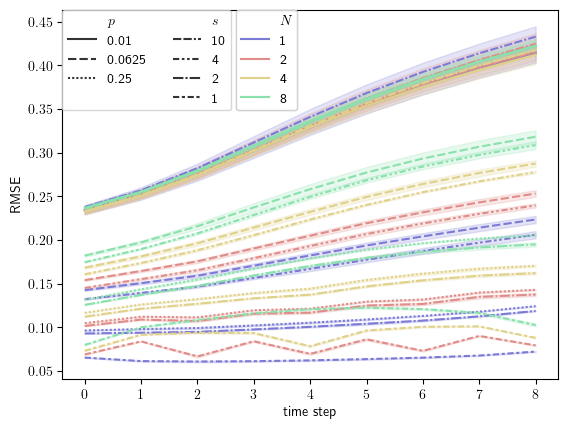

In [79]:
to_plot = sin3x_soad
n_mask_params = len(to_plot["rand_mask_ratio"].unique()) + 1
ax = sns.lineplot(
    to_plot, x="step_idx", y="rmse", hue="time_stride", style="rand_mask_ratio", errorbar="sd", palette=palette
)

handles, labels = ax.get_legend_handles_labels()

ratio_handles = [handles[-n_mask_params]]
ratio_labels = [labels[-n_mask_params]]
# 1st column
idxs = [1, 2, 3]
for idx in idxs:
    ratio_handles.append(handles[-n_mask_params + idx])
    ratio_labels.append(labels[-n_mask_params + idx])

# 2nd column
ratio_handles.append(handles[-n_mask_params])  # empty style
ratio_labels.append("")  # empty string
ratio_handles.append(handles[-n_mask_params])  # empty style
ratio_labels.append("")  # empty string
idxs = [7, 6, 5, 4]
for idx in idxs:
    ratio_handles.append(handles[-n_mask_params + idx])
    ratio_labels.append(labels[-n_mask_params + idx])
ratio_hl = [ratio_handles, ratio_labels]

# ratio_hl = [handles[-n_mask_params:], labels[-n_mask_params:]]
stride_hl = [handles[:-n_mask_params], labels[:-n_mask_params]]

ratio_hl[1][0] = "$p$"
ratio_hl[1][5] = "$s$"
stride_hl[1][0] = "$N$"
for k, s in enumerate(ratio_hl[1]):
    if s.endswith(".0"):
        ratio_hl[1][k] = s[:-2]

ratio_leg = ax.legend(*ratio_hl, loc="upper left", borderaxespad=0.0, ncols=2)
stride_leg = ax.legend(*stride_hl, loc="upper left", bbox_to_anchor=(0.35, 1.0), borderaxespad=0.0)

ax.add_artist(ratio_leg)
ax.add_artist(stride_leg)

plt.xlabel("time step")
plt.ylabel("RMSE")

plt.savefig("../figs/assimilate_with_prior_sin3x_soad.pdf")
# plt.ylim(.1, .5)
# plt.yscale('log')

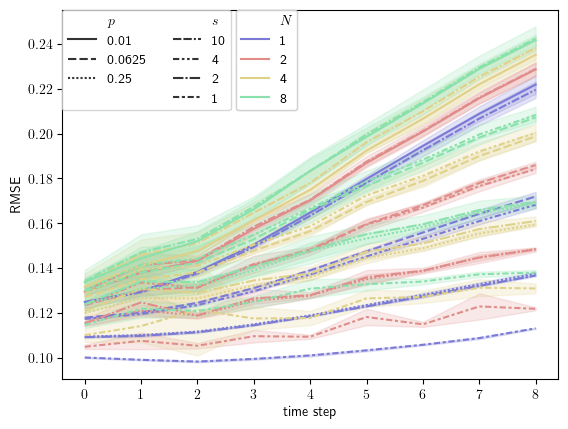

In [80]:
to_plot = vor2vel_soad
n_mask_params = len(to_plot["rand_mask_ratio"].unique()) + 1
ax = sns.lineplot(
    to_plot, x="step_idx", y="rmse", hue="time_stride", style="rand_mask_ratio", errorbar="sd", palette=palette
)

handles, labels = ax.get_legend_handles_labels()

ratio_handles = [handles[-n_mask_params]]
ratio_labels = [labels[-n_mask_params]]
# 1st column
idxs = [1, 2, 3]
for idx in idxs:
    ratio_handles.append(handles[-n_mask_params + idx])
    ratio_labels.append(labels[-n_mask_params + idx])

# 2nd column
ratio_handles.append(handles[-n_mask_params])  # empty style
ratio_labels.append("")  # empty string
ratio_handles.append(handles[-n_mask_params])  # empty style
ratio_labels.append("")  # empty string
idxs = [7, 6, 5, 4]
for idx in idxs:
    ratio_handles.append(handles[-n_mask_params + idx])
    ratio_labels.append(labels[-n_mask_params + idx])
ratio_hl = [ratio_handles, ratio_labels]

# ratio_hl = [handles[-n_mask_params:], labels[-n_mask_params:]]
stride_hl = [handles[:-n_mask_params], labels[:-n_mask_params]]

ratio_hl[1][0] = "$p$"
ratio_hl[1][5] = "$s$"
stride_hl[1][0] = "$N$"
for k, s in enumerate(ratio_hl[1]):
    if s.endswith(".0"):
        ratio_hl[1][k] = s[:-2]

ratio_leg = ax.legend(*ratio_hl, loc="upper left", borderaxespad=0.0, ncols=2)
stride_leg = ax.legend(*stride_hl, loc="upper left", bbox_to_anchor=(0.35, 1.0), borderaxespad=0.0)

ax.add_artist(ratio_leg)
ax.add_artist(stride_leg)

plt.xlabel("time step")
plt.ylabel("RMSE")

plt.savefig("../figs/assimilate_with_prior_vor2vel_soad.pdf")
# plt.ylim(.1, .5)
# plt.yscale('log')

In [81]:
arctan3x_sda

,obs_type,method,rand_mask_ratio,seed_no,rmse,step_idx,time_stride,avg_rmse
0,arctan3x,sda,2.00,0,2.507723,0,1,2.395776
1,arctan3x,sda,2.00,0,2.482472,1,1,2.395776
2,arctan3x,sda,2.00,0,2.453311,2,1,2.395776
3,arctan3x,sda,2.00,0,2.425040,3,1,2.395776
4,arctan3x,sda,2.00,0,2.395625,4,1,2.395776
...,...,...,...,...,...,...,...,...
4,arctan3x,sda,0.01,4,1.794057,4,8,1.795930
5,arctan3x,sda,0.01,4,1.788994,5,8,1.795930
6,arctan3x,sda,0.01,4,1.784646,6,8,1.795930
7,arctan3x,sda,0.01,4,1.780891,7,8,1.795930


In [83]:
grouped = arctan3x.groupby(["rand_mask_ratio", "step_idx", "time_stride"])
f = grouped.agg({"rmse": ["mean", "std"]})
f

rmse          
                                          mean       std
rand_mask_ratio step_idx time_stride                    
0.01            0        1            1.283336  1.230818
                         2            1.249257  1.198916
                         4            1.240747  1.190070
                         8            1.225471  1.175283
                1        1            1.288847  1.225674
...                                        ...       ...
10.00           7        8            1.298781  1.112122
                8        1            1.347509  1.164097
                         2            1.319578  1.129393
                         4            1.316975  1.117676
                         8            1.304060  1.099077

[252 rows x 2 columns]

In [ ]:
def plot_avg_cases(x: pd.DataFrame, save_path: str):
    grouped = x.groupby(["rand_mask_ratio", "step_idx", "time_stride"])
    f = grouped.agg({"rmse": ["mean", "std"]})
    ff = f.groupby(["rand_mask_ratio", "time_stride"]).mean()
    ff = ff.reset_index()
    df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")
    print(df_pivot)

    vmin, vmax = (0.05, 0.5)  # if 'arctan' in save_path else (0., 1.)

    # annot_data = np.asarray(df_pivot.values)
    # annot_str = np.empty(annot_data.shape, dtype=str)
    # for ii in range(annot_data.shape[0]):
    #     for jj in range(annot_data.shape[1]):
    #         annot_str[ii, jj] = ">1" if annot_data[ii, jj] > 1 else f"{annot_data[ii, jj]:.3f}"

    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_over("slategray")

    ax = sns.heatmap(
        df_pivot,
        annot=True,
        annot_kws={"size": 12},
        fmt=".3f",
        linewidths=0.5,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={"extend": "max", "label": "RMSE"},
    )
    ax.set_yticklabels(["$p=0.01$", "$p=0.0625$", "$p=0.25$", "$s=p=1$", "$s=2$", "$s=4$", "$s=10$"], rotation=0)
    ax.set_xticklabels(["$N=1$", "$N=2$", "$N=4$", "$N=8$"], rotation=45)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.savefig(save_path)

/tmp/ipykernel_679817/566218022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           2.407710  2.337535  2.320009  2.286963
0.0625           2.507938  2.337289  2.276557  2.113984
0.2500           2.649411  2.270784  2.221036  1.902202
1.0000           2.760217  1.943360  1.855086  1.440355
2.0000           2.694715  2.282087  2.281676  1.977370
4.0000           2.541174  2.326230  2.304205  2.151978
10.0000          2.457060  2.385641  2.368347  2.334159


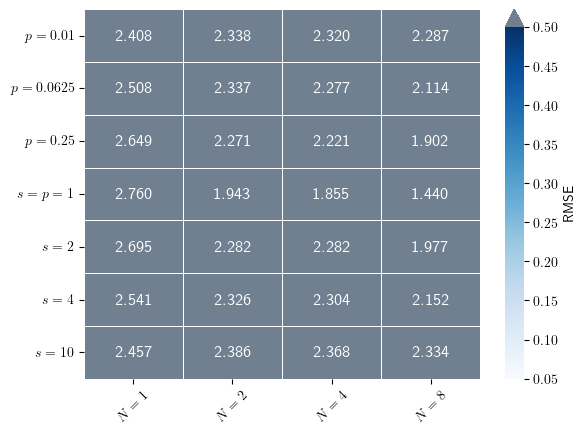

In [85]:
plot_avg_cases(arctan3x_sda, save_path="../figs/assimilate_with_prior_arctan3x_sda_heatmap.pdf")

/tmp/ipykernel_679817/566218022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           0.207605  0.212298  0.217332  0.221729
0.0625           0.146148  0.156492  0.168552  0.179767
0.2500           0.110003  0.119753  0.130071  0.141232
1.0000           0.084417  0.093567  0.101971  0.112196
2.0000           0.107938  0.117890  0.127677  0.137745
4.0000           0.140559  0.151286  0.164280  0.175625
10.0000          0.200022  0.206668  0.213436  0.218741


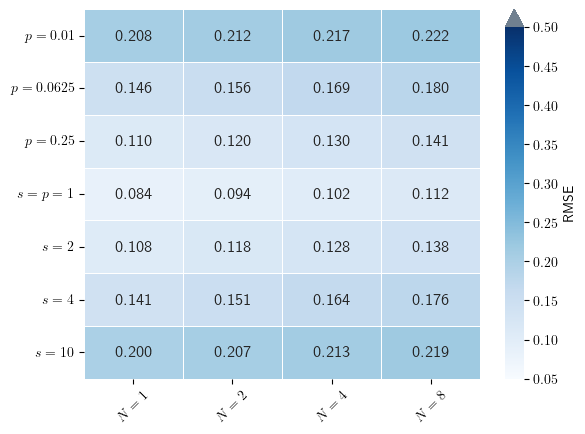

In [86]:
plot_avg_cases(arctan3x_soad, save_path="../figs/assimilate_with_prior_arctan3x_soad_heatmap.pdf")

/tmp/ipykernel_679817/566218022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           2.663617  2.544976  2.469227  2.434875
0.0625           3.139872  2.981808  2.879301  2.814399
0.2500           3.685922  3.351497  3.221334  3.173877
1.0000           4.331577  4.008076  3.804329  3.650448
2.0000           3.653994  3.414765  3.269618  3.241881
4.0000           3.185007  3.010323  2.930255  2.895031
10.0000          2.713323  2.609314  2.528699  2.489863


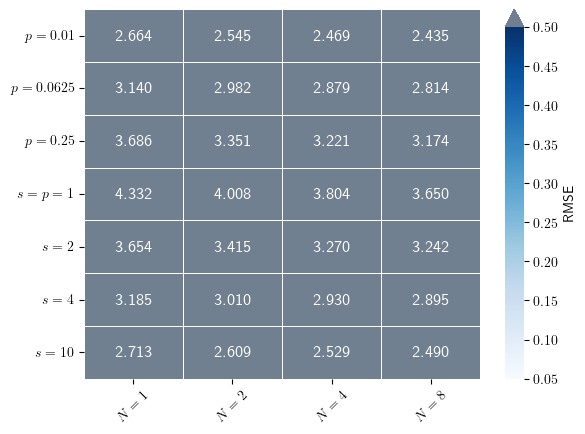

In [87]:
plot_avg_cases(sin3x_sda, save_path="../figs/assimilate_with_prior_sin3x_sda_heatmap.pdf")

/tmp/ipykernel_679817/566218022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           0.325831  0.326941  0.325076  0.332203
0.0625           0.182282  0.204055  0.229996  0.254049
0.2500           0.107186  0.123681  0.145701  0.174241
1.0000           0.064349  0.077951  0.090648  0.109701
2.0000           0.102500  0.119324  0.139215  0.165814
4.0000           0.167712  0.192572  0.221331  0.245428
10.0000          0.337524  0.331825  0.327429  0.331148


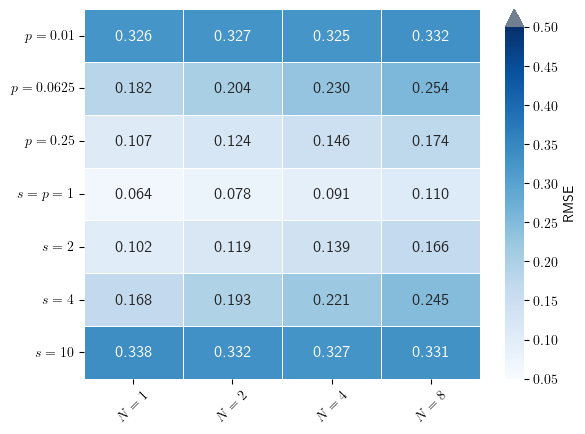

In [88]:
plot_avg_cases(sin3x_soad, save_path="../figs/assimilate_with_prior_sin3x_soad_heatmap.pdf")

/tmp/ipykernel_679817/566218022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                     mean                              
time_stride             1         2         4         8
rand_mask_ratio                                        
0.0100           0.168134  0.174494  0.179198  0.184679
0.0625           0.141394  0.151848  0.160166  0.166464
0.2500           0.120821  0.130641  0.138859  0.146514
1.0000           0.103293  0.112795  0.121896  0.128392
2.0000           0.120303  0.131269  0.141060  0.147855
4.0000           0.139436  0.151682  0.162691  0.168059
10.0000          0.166780  0.175242  0.182563  0.185631


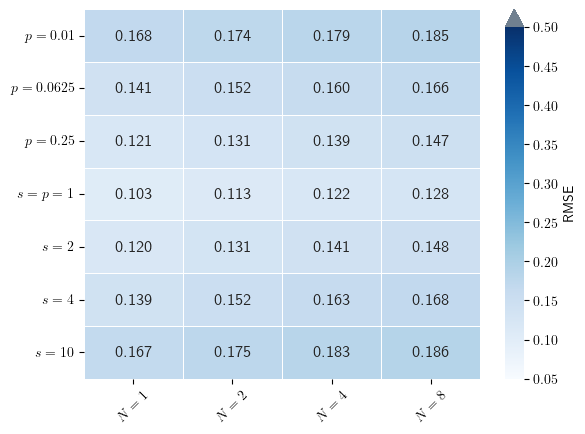

In [89]:
plot_avg_cases(vor2vel_soad, save_path="../figs/assimilate_with_prior_vor2vel_soad_heatmap.pdf")

/tmp/ipykernel_679817/566218022.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_pivot = ff.pivot_table(index="rand_mask_ratio", columns="time_stride", values="rmse").drop(columns="std")


                      mean                              
time_stride              1         2         4         8
rand_mask_ratio                                         
0.0100            2.983653  1.658573  1.278890  1.214762
0.0625           14.865897  7.348106  6.857944  6.524569
0.2500           15.079091  7.409264  7.056086  6.712265
1.0000           15.219964  7.716729  7.072083  6.760583
2.0000           15.165974  7.548034  7.039288  6.698334
4.0000           14.720242  7.241986  6.972534  6.722745
10.0000           3.141586  1.554008  1.343812  1.226801


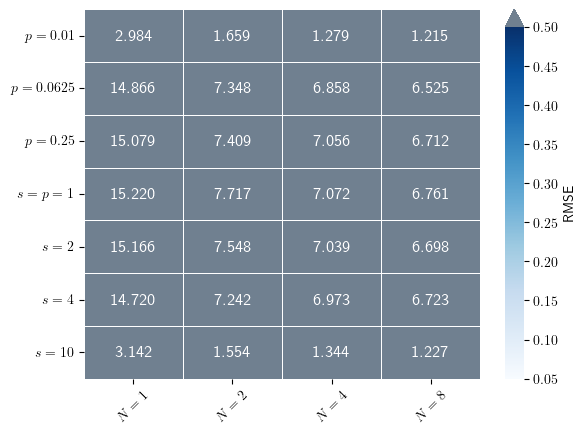

In [90]:
plot_avg_cases(vor2vel_sda, save_path="../figs/assimilate_with_prior_vor2vel_sda_heatmap.pdf")